In [1]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import AutoTokenizer
import pytorch

random.seed(6)
np.random.seed(6)


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# Experiment 6 - MCQ Long answer HTML tags

For this experiment I changed the system prompt, asking the LLM to generate more text (about "thinking") and then give the final answer.


**Parameters:**
- model: deepseek-r1:7b
- system prompt: MCQ_system_prompt_v3.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [2]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [3]:
# needed to modify the output file because of the bug
# I introduced in the code
predictions = []
with open('../outputs/responses_deepseek-r1:7b_20250219_13:52:42.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,"<think> Okay, so I need to figure out which ob..."
Interaction_T1_14,"<think> Okay, so I need to figure out which ob..."
Interaction_T1_31,"<think> Okay, so I need to figure out which ob..."
Interaction_T1_32,"<think> Okay, so I need to figure out which ob..."
Interaction_T1_40,"<think> Okay, so I need to figure out which ob..."
...,...
Feasibility_T6_1453,"<think> Okay, so I'm trying to figure out what..."
Feasibility_T6_1454,"<think> Okay, so I need to figure out what the..."
Feasibility_T6_1455,"<think> Alright, so I'm trying to figure out w..."


In [4]:
predictions_df.iloc[0:20]['answer'].apply(print)


<think>
Okay, so I need to figure out which object was tidied up by the person based on the given Spatio-Temporal Scene Graphs (STSG). Let me start by understanding what each scene graph represents and how they change over time.

Looking at the question, it's asking about an object that was tidied up by the person. The alternatives are a closet/cabinet, a blanket, clothes, or a table. I'll need to see which of these is being tidied based on the relationships in the STSGs.

First, I'll go through each scene graph step by step and note any changes in the relationships that might indicate tidying up.

The first few frames show the person in front of the clothes, holding it. Then, over time, more objects are added or moved. For example, in one frame, the person is holding a towel and in front of a towel, clothes, and blanket. Another shows the person touching the towel while holding the clothes.

I notice that towards the end of the STSGs, there's a scene where the person is holding the to

id
Interaction_T1_13     None
Interaction_T1_14     None
Interaction_T1_31     None
Interaction_T1_32     None
Interaction_T1_40     None
Interaction_T1_43     None
Interaction_T1_70     None
Interaction_T1_71     None
Interaction_T1_76     None
Interaction_T1_78     None
Interaction_T1_81     None
Interaction_T1_95     None
Interaction_T1_100    None
Interaction_T1_101    None
Interaction_T1_104    None
Interaction_T1_106    None
Interaction_T1_111    None
Interaction_T1_137    None
Interaction_T1_139    None
Interaction_T1_147    None
Name: answer, dtype: object

In [5]:
# Check if the the template is somewhere in the answer
html_tags_pattern = r'<Final answer>\s*A:\s*\d\.\s*((?:\w+(?:\s|\/)?){,10}\.)\s*</Final answer>'
html_tags_mask = predictions_df['answer'].str.contains(html_tags_pattern, case=False, regex=True)


print(f"Answer following the template: {html_tags_mask.value_counts()[True]}\n"
      f"{html_tags_mask.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {html_tags_mask.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 2467
34.76% of the total

Only 4631 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_31560/447578442.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  html_tags_mask = predictions_df['answer'].str.contains(html_tags_pattern, case=False, regex=True)


Let's start by viewing how many answers follow the template:

In [6]:
# Check if the the template is somewhere in the answer
#
# An example of the template expressed by the regex is: A: 1. The answer.
# where the number followed by a dot is optional
ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:\w+(?:\s|\/)?){,10}\.)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


/tmp/ipykernel_31560/2545864474.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


Answer following the template: 6840
96.37% of the total

Only 258 samples do not contain the answer in the response with the specified format


In [7]:
# Check that contains answer is subset of html_tags
assert (html_tags_mask & contains_answer).sum() == html_tags_mask.sum()


## Non-conforming responses

In [8]:
predictions_df.loc[~html_tags_mask].iloc[:5]['answer'].apply(lambda x: print(x, '\n\n'))


<think>
Okay, so I need to figure out which object was tidied up by the person based on the given Spatio-Temporal Scene Graphs (STSG). Let me start by understanding what each scene graph represents and how they change over time.

Looking at the question, it's asking about an object that was tidied up by the person. The alternatives are a closet/cabinet, a blanket, clothes, or a table. I'll need to see which of these is being tidied based on the relationships in the STSGs.

First, I'll go through each scene graph step by step and note any changes in the relationships that might indicate tidying up.

The first few frames show the person in front of the clothes, holding it. Then, over time, more objects are added or moved. For example, in one frame, the person is holding a towel and in front of a towel, clothes, and blanket. Another shows the person touching the towel while holding the clothes.

I notice that towards the end of the STSGs, there's a scene where the person is holding the to

id
Interaction_T1_13     None
Interaction_T1_14     None
Interaction_T1_40     None
Interaction_T1_100    None
Interaction_T1_101    None
Name: answer, dtype: object

In [9]:
predictions_df.loc[~contains_answer].iloc[:100]['answer'].apply(lambda x: print(x, '\n\n'))


<think>
Okay, so I need to figure out which object was opened by the person based on the given Spatio-Temporal Scene Graphs (STSG). Let me start by understanding what each part of the data represents.

First, looking at the question: "Which object was opened by the person?" The alternatives are a refrigerator, a box, a door, or a laptop. I need to determine which one is correct based on the STSG provided.

The STSG consists of multiple scene graphs in chronological order. Each scene graph has triples in the format [subject - relationship - object]. My task is to analyze these triples across all time steps to find out what action occurred that involved opening an object.

Looking at the first few frames, I see "person - wearing - clothes" and "person - holding - laptop". This suggests that initially, the person has a laptop. Then, in later frames, there's "person - touching - laptop", which might indicate interaction with the laptop but not necessarily opening it yet.

As we go through 

id
Interaction_T1_379     None
Interaction_T1_459     None
Interaction_T1_1265    None
Interaction_T1_1513    None
Interaction_T1_2616    None
                       ... 
Interaction_T4_2845    None
Interaction_T4_3321    None
Interaction_T4_3363    None
Interaction_T4_3688    None
Interaction_T4_3728    None
Name: answer, Length: 100, dtype: object

In [10]:
# Note: to access meta-llama you have to first accept the licence agreement
hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
                'meta-llama/Llama-3.2-3B-Instruct', 
                token=hugg_key)


In [11]:
resp_token_len = pd.Series(index=predictions_df.index)

for index, row in predictions_df.iterrows():
    resp_token_len.loc[index] = len(tokenizer.encode(row['answer']))

resp_token_len.sort_values().value_counts(sort=False)


/tmp/ipykernel_31560/4005420109.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  resp_token_len = pd.Series(index=predictions_df.index)


12.0      235
154.0       1
164.0       1
168.0       1
178.0       1
         ... 
5195.0      1
5372.0      1
5750.0      1
5762.0      1
5795.0      1
Length: 1444, dtype: int64

The responses with a token length of 12 are those that caused an error during generation (mainly due to time-out 4mins):

In [12]:
(predictions_df[resp_token_len == 12] == "Error while generating the response. Look at the logs.").all()


answer    True
dtype: bool

In [13]:

print(f"Number of responses that are not conformat to the regex: {predictions_df[~contains_answer].shape[0]}")
print(f"Number of responses that took too long to answer:        {(resp_token_len == 12).sum()}")


Number of responses that are not conformat to the regex: 258
Number of responses that took too long to answer:        235


In [14]:
predictions_df[(~contains_answer) & ~(resp_token_len == 12)]['answer'].apply(lambda x: print(x, '\n\n'))


<think>
Okay, so I need to figure out which object was opened by the person based on the given Spatio-Temporal Scene Graphs (STSG). Let me start by understanding what each part of the data represents.

First, looking at the question: "Which object was opened by the person?" The alternatives are a refrigerator, a box, a door, or a laptop. I need to determine which one is correct based on the STSG provided.

The STSG consists of multiple scene graphs in chronological order. Each scene graph has triples in the format [subject - relationship - object]. My task is to analyze these triples across all time steps to find out what action occurred that involved opening an object.

Looking at the first few frames, I see "person - wearing - clothes" and "person - holding - laptop". This suggests that initially, the person has a laptop. Then, in later frames, there's "person - touching - laptop", which might indicate interaction with the laptop but not necessarily opening it yet.

As we go through 

id
Interaction_T1_379     None
Interaction_T1_7184    None
Interaction_T1_7289    None
Interaction_T1_7781    None
Interaction_T1_8535    None
Interaction_T3_5406    None
Interaction_T4_1740    None
Sequence_T1_1722       None
Sequence_T1_1745       None
Sequence_T1_7150       None
Sequence_T2_2264       None
Sequence_T2_3247       None
Sequence_T2_3950       None
Sequence_T2_4968       None
Sequence_T3_438        None
Sequence_T4_105        None
Sequence_T4_4018       None
Sequence_T4_4394       None
Feasibility_T5_301     None
Feasibility_T5_393     None
Feasibility_T5_938     None
Feasibility_T5_1852    None
Feasibility_T5_1908    None
Name: answer, dtype: object

## Distribution of generated response lengths measured in tokens

count    7098.000000
mean      607.920682
std       522.625505
min        12.000000
25%       347.250000
50%       453.000000
75%       671.000000
max      5795.000000
dtype: float64

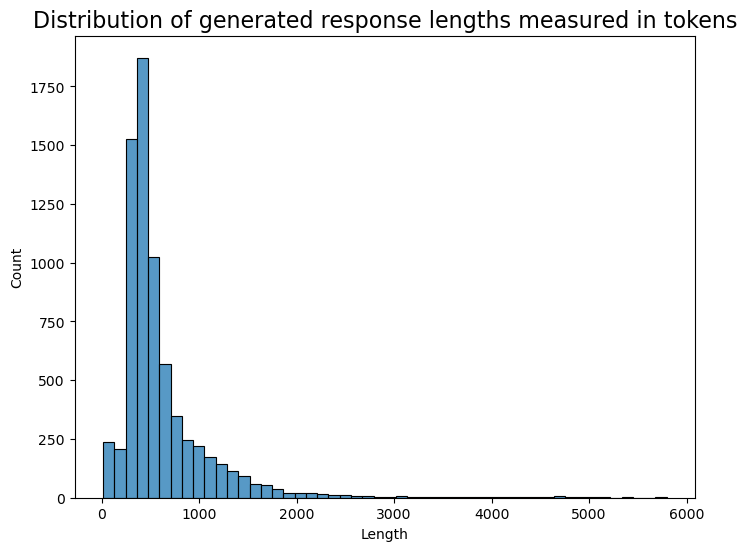

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(resp_token_len, bins=50)
plt.title("Distribution of generated response lengths measured in tokens", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")

resp_token_len.describe()


## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [16]:
ans_df = predictions_df.loc[contains_answer]['answer'].str.extract(ans_regex_pattern)
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The clothes.
Interaction_T1_31,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
...,...
Feasibility_T6_1453,The table.
Feasibility_T6_1454,Take the towel.
Feasibility_T6_1455,The table.


In [17]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 610 unique answers


In [18]:
ans_df['text'].value_counts()


The clothes.                  1968
The towel.                     382
The bag.                       213
Put down.                      208
The book.                      203
                              ... 
Wash the window.                 1
Take the blanket.                1
Sit on the table.                1
Throw the clothes.               1
Take the cup/glass/bottle.       1
Name: text, Length: 305, dtype: Int64

<AxesSubplot: xlabel='freq', ylabel='word'>

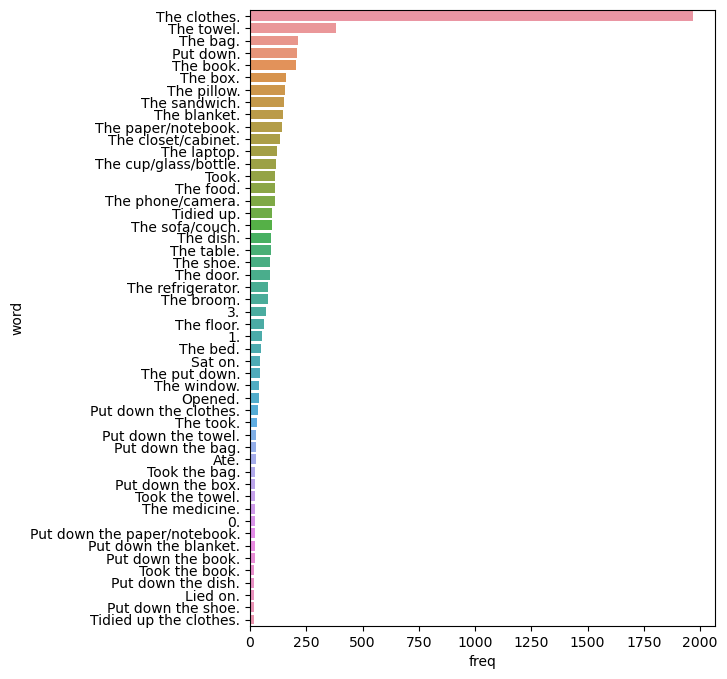

In [19]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [20]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


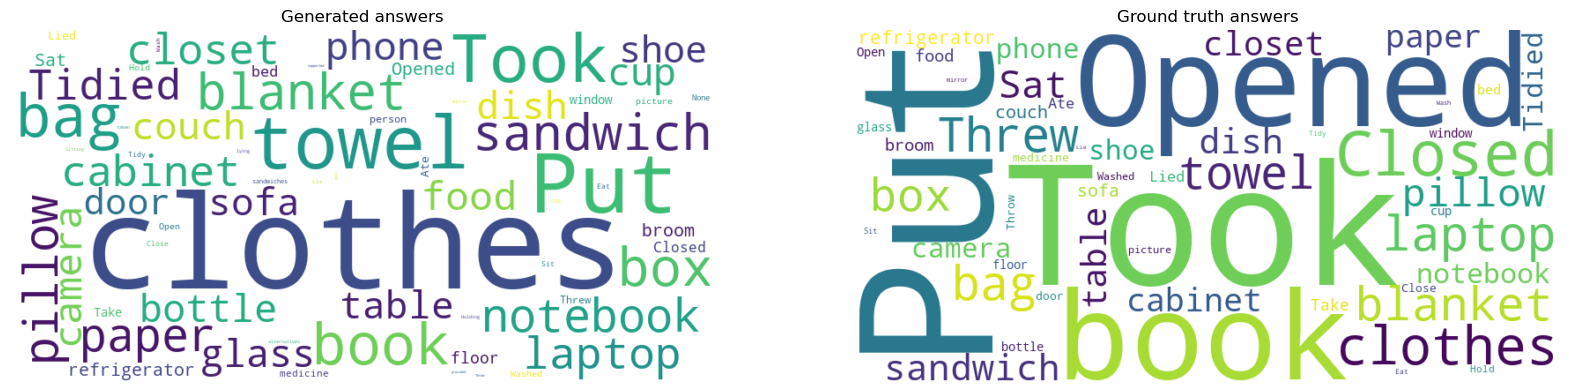

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(ans_df['text'].astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_df['text'].astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

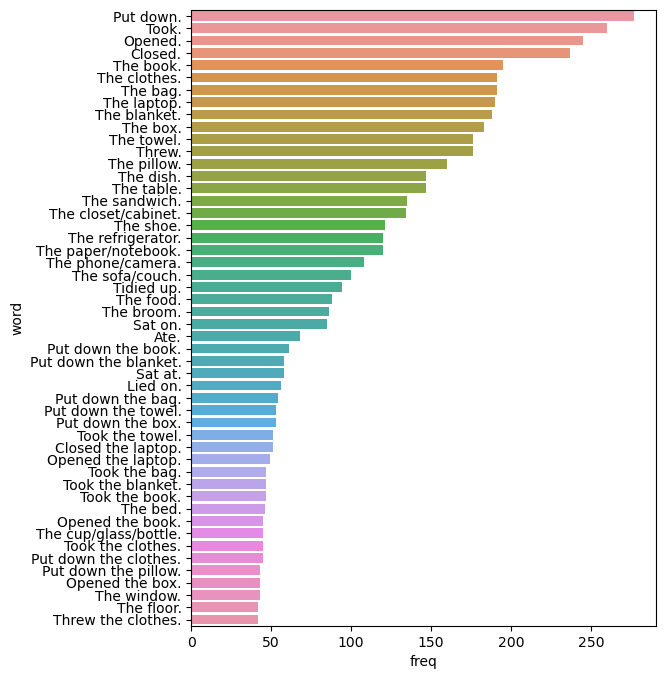

In [22]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [25]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6840, 4)

In [26]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'] == eval_df[on_what]).sum()
    

    return hits_text/eval_df.shape[0]


In [27]:
text_acc = accuracy(eval_df)

print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 37.89%


In [28]:
eval_df[eval_df['text'] == eval_df['pred_text']]


,choices,num,text,pred_text
id,,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,The shoe.
Interaction_T1_43,"{'0': 'The box.', '1': 'The pillow.', '2': 'Th...",3,The clothes.,The clothes.
...,...,...,...,...
Feasibility_T6_1364,"{'0': 'Take the book.', '1': 'Hold the mirror....",0,Take the book.,Take the book.
Feasibility_T6_1370,"{'0': 'Tidy up the blanket.', '1': 'Open the b...",1,Open the box.,Open the box.
Feasibility_T6_1392,"{'0': 'Open the laptop.', '1': 'Tidy up the cl...",3,Put down the broom.,Put down the broom.


check if the equality with NA result in a false or is skipped

In [29]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 36.52%


In [30]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [31]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2295        41.26%  
Sequence            3468        36.22%  
Prediction           601        37.44%  
Feasibility          476        34.45%  


In [32]:
index_intersect = predictions_df[html_tags_mask].index.intersection(eval_df.index)
print_acc(eval_df.loc[index_intersect], accuracy)


Question type       Total      Accuracy 

Interaction          872        39.68%  
Sequence            1187        36.56%  
Prediction           271        39.48%  
Feasibility          137        32.85%  


In [33]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        95.70%  
Sequence            3586        96.71%  
Prediction           624        96.31%  
Feasibility          490        97.14%  
Overall             7098        96.37%  
